# REBER Grammar with RNN

In this workbook, we are going to set-up multiple Recurrent Neural Network to test them using as test <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words.

## What is a Reber Word ?

A Reber word is a word following the Reber's grammar. The grammar is based on the following graph:

<img src="reber.gif"/>

The word must start with B, then it can be either T or P and so on until it reaches E. To prepare datas for this, we are going to use a OneHotEncoder to have 7 inputs, n timesteps (depending on the length of the word) and k batches. To generate it, I use the algorith from <a href="http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php" target="_target">this site</a> but slightly modified to be able to validate also embedded Word

The Embedded version of the Reber Grammar using the following graph :

<img src="embreber.gif"/>

Due to current technologies, we will focus on Embedded Word (both system tried below with Simple Reber Word reaches 100% success and cannot be compared)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

Using TensorFlow backend.


## Preparation of datas

For the OneHotEncoder, the chain 'BTSXPVE' will be used. We can now try only 1 example to check the output

In [2]:
x, y = reber.get_one_embedded_example(minLength=10)
print(reber.sequenceToWord(x))
print(x[0], y[0])

BTBTXXTTTTTTTTVPXVPXTVPXVVET
[ 1.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  1.  0.  0.]


*y* is the possible outcome for a given input. That means B ([ 1.  0.  0.  0.  0.  0.  0.]) can be followed by T or P ([ 0.  1.  0.  0.  1.  0.  0.]).

However, we won't use y as output but for every timestep, we are going to provide the next timestep as target. For this, we will use the following function

In [3]:
def generate(x0):
    end = np.array([0.,  0.,  0.,  0.,  0.,  0.,  1.])
    y=x0[1:]
    y.append(end)
    return y

Now, if we take as input "BTSXS", the output will be "TSXSE" (but the input in encoded).

We can also generate few words to check the output.

In [5]:
min_length = 25
for i in range(10):
    inp, out = reber.get_one_embedded_example(min_length)
#     print(reber.sequenceToWord(inp))
    print(len(inp))

29
33
31
29
36
29
34
33
36
33


So we have the first "problem" now, the length of the string is variable. So when we are going to generate our test/train datas, we will have to pad them to the same length (let's say 20). This is done by using <b>sequence.pad_sequences</b> for Keras Library. The padding will be done as "post" to improve accuracy. Using a "pre" padding reduce accuracy because the cell doesn't know how many times it will receive 0 instead of "E"

In [6]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []
y_possible = []

maxlen = 0
for i in range(2048):
    x, y = reber.get_one_embedded_example(min_length)
    X_train.append(x)
    y_train.append(generate(x))
    maxlen = max(maxlen, len(x))

for i in range(256):
    x, y = reber.get_one_embedded_example(min_length)
    X_test.append(x)
    y_test.append(generate(x))
    maxlen = max(maxlen, len(x))
    
for i in range(1):
    x, y = reber.get_one_embedded_example(min_length)
    X_val.append(x)
    y_val.append(generate(x))
    y_possible.append(y)
    maxlen = max(maxlen, len(x))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_possible = np.array(y_possible)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
y_test = sequence.pad_sequences(y_test, maxlen=maxlen, padding='post', truncating='post')
X_val = sequence.pad_sequences(X_val, maxlen=maxlen, padding='post', truncating='post')
y_val = sequence.pad_sequences(y_val, maxlen=maxlen, padding='post', truncating='post')
y_possible = sequence.pad_sequences(y_possible, maxlen=maxlen, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(y_possible.shape)

(2048, 53, 7)
(2048, 53, 7)
(256, 53, 7)
(256, 53, 7)
(1, 53, 7)
(1, 53, 7)
(1, 53, 7)


In [6]:
print(y_possible)

[[[0 1 0 0 1 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 1 0 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 1 0 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


So now we have 2048 strings for training, 256 for test and 1 just for visualisation later. We can now set-up our model.

## Test of RNNs

For this model, we are going to use a many-to-many RNN. That means for every input, the model will predict an output. The training will be done based on the input we prepared previously. Once trained. We will be able to "transfer" the learning to a one-to-many model in order to have a "generator".

<img src="RNN_types.jpg"/>

What we expect is a probability of having this or this letter. The problem is a multi-class classifier. As a reult, the loss function will be the categorical crossentropy

In [7]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "categorical_crossentropy"
metrics_ = "categorical_crossentropy"
optimizer_ = "Nadam"
nb_epoch = 250
batch_size = 64

### LSTM

The first model we will setup is an <b>LSTM</b> which means <b>L</b>ong <b>S</b>hort-<b>T</b>erm <b>M</b>emory. The principle is 
quite complex but very powerfull for long sequences inputs (because there is less issues with Vanishing Gradient Problem) or long term memory (You can refer to <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/" target="_blank">this link</a> for more informations)

LSTM is widely for speech recognition, Natural Language processing, Sentiment Analysis.

In [8]:
model = Sequential()

model.add(LSTM(units=nb_unit, 
               input_shape=inp_shape, 
               return_sequences=True))  # single LSTM
model.add(Dense(7, activation='softmax'))
model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("lstm_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [9]:
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 53, 7)
Outputs: (None, 53, 7)
Actual input: (2048, 53, 7)
Actual output: (2048, 53, 7)


In [10]:
start = time.time()
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t1 = stop-start
print(model.summary())
print("Training time : {}s".format(t1))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 1.11962, saving model to lstm_simple.h5
 - 4s - loss: 1.1196 - categorical_crossentropy: 1.1196 - val_loss: 1.0798 - val_categorical_crossentropy: 1.0798
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 1.11962 to 1.03148, saving model to lstm_simple.h5
 - 2s - loss: 1.0315 - categorical_crossentropy: 1.0315 - val_loss: 0.9863 - val_categorical_crossentropy: 0.9863
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 1.03148 to 0.96066, saving model to lstm_simple.h5
 - 2s - loss: 0.9607 - categorical_crossentropy: 0.9607 - val_loss: 0.9199 - val_categorical_crossentropy: 0.9199
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 0.96066 to 0.88719, saving model to lstm_simple.h5
 - 2s - loss: 0.8872 - categorical_crossentropy: 0.8872 - val_loss: 0.8533 - val_categorical_crossentropy: 0.8533
Epoch 5/250
Epoch 00005: categorical_cros

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.31395 to 0.31076, saving model to lstm_simple.h5
 - 2s - loss: 0.3108 - categorical_crossentropy: 0.3108 - val_loss: 0.3102 - val_categorical_crossentropy: 0.3102
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.31076 to 0.30848, saving model to lstm_simple.h5
 - 2s - loss: 0.3085 - categorical_crossentropy: 0.3085 - val_loss: 0.3075 - val_categorical_crossentropy: 0.3075
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.30848 to 0.30615, saving model to lstm_simple.h5
 - 2s - loss: 0.3062 - categorical_crossentropy: 0.3062 - val_loss: 0.3085 - val_categorical_crossentropy: 0.3085
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.30615 to 0.30394, saving model to lstm_simple.h5
 - 2s - loss: 0.3039 - categorical_crossentropy: 0.3039 - val_loss: 0.3030 - val_categorical_crossentropy: 0.3030
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.30394 to 0.30

Epoch 00073: categorical_crossentropy improved from 0.27141 to 0.27054, saving model to lstm_simple.h5
 - 2s - loss: 0.2705 - categorical_crossentropy: 0.2705 - val_loss: 0.2711 - val_categorical_crossentropy: 0.2711
Epoch 74/250
Epoch 00074: categorical_crossentropy improved from 0.27054 to 0.27052, saving model to lstm_simple.h5
 - 2s - loss: 0.2705 - categorical_crossentropy: 0.2705 - val_loss: 0.2715 - val_categorical_crossentropy: 0.2715
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.27052 to 0.27017, saving model to lstm_simple.h5
 - 2s - loss: 0.2702 - categorical_crossentropy: 0.2702 - val_loss: 0.2700 - val_categorical_crossentropy: 0.2700
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.27017 to 0.26907, saving model to lstm_simple.h5
 - 2s - loss: 0.2691 - categorical_crossentropy: 0.2691 - val_loss: 0.2701 - val_categorical_crossentropy: 0.2701
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.26907 to 0.26883, saving m

Epoch 112/250
Epoch 00112: categorical_crossentropy did not improve
 - 2s - loss: 0.2626 - categorical_crossentropy: 0.2626 - val_loss: 0.2634 - val_categorical_crossentropy: 0.2634
Epoch 113/250
Epoch 00113: categorical_crossentropy improved from 0.26217 to 0.26197, saving model to lstm_simple.h5
 - 2s - loss: 0.2620 - categorical_crossentropy: 0.2620 - val_loss: 0.2633 - val_categorical_crossentropy: 0.2633
Epoch 114/250
Epoch 00114: categorical_crossentropy did not improve
 - 2s - loss: 0.2620 - categorical_crossentropy: 0.2620 - val_loss: 0.2636 - val_categorical_crossentropy: 0.2636
Epoch 115/250
Epoch 00115: categorical_crossentropy did not improve
 - 2s - loss: 0.2621 - categorical_crossentropy: 0.2621 - val_loss: 0.2626 - val_categorical_crossentropy: 0.2626
Epoch 116/250
Epoch 00116: categorical_crossentropy improved from 0.26197 to 0.26193, saving model to lstm_simple.h5
 - 2s - loss: 0.2619 - categorical_crossentropy: 0.2619 - val_loss: 0.2634 - val_categorical_crossentropy:

Epoch 152/250
Epoch 00152: categorical_crossentropy did not improve
 - 2s - loss: 0.2594 - categorical_crossentropy: 0.2594 - val_loss: 0.2604 - val_categorical_crossentropy: 0.2604
Epoch 153/250
Epoch 00153: categorical_crossentropy improved from 0.25930 to 0.25922, saving model to lstm_simple.h5
 - 2s - loss: 0.2592 - categorical_crossentropy: 0.2592 - val_loss: 0.2610 - val_categorical_crossentropy: 0.2610
Epoch 154/250
Epoch 00154: categorical_crossentropy improved from 0.25922 to 0.25896, saving model to lstm_simple.h5
 - 2s - loss: 0.2590 - categorical_crossentropy: 0.2590 - val_loss: 0.2608 - val_categorical_crossentropy: 0.2608
Epoch 155/250
Epoch 00155: categorical_crossentropy did not improve
 - 2s - loss: 0.2592 - categorical_crossentropy: 0.2592 - val_loss: 0.2606 - val_categorical_crossentropy: 0.2606
Epoch 156/250
Epoch 00156: categorical_crossentropy did not improve
 - 2s - loss: 0.2594 - categorical_crossentropy: 0.2594 - val_loss: 0.2606 - val_categorical_crossentropy:

Epoch 194/250
Epoch 00194: categorical_crossentropy improved from 0.25789 to 0.25775, saving model to lstm_simple.h5
 - 2s - loss: 0.2577 - categorical_crossentropy: 0.2577 - val_loss: 0.2599 - val_categorical_crossentropy: 0.2599
Epoch 195/250
Epoch 00195: categorical_crossentropy improved from 0.25775 to 0.25770, saving model to lstm_simple.h5
 - 2s - loss: 0.2577 - categorical_crossentropy: 0.2577 - val_loss: 0.2591 - val_categorical_crossentropy: 0.2591
Epoch 196/250
Epoch 00196: categorical_crossentropy did not improve
 - 2s - loss: 0.2578 - categorical_crossentropy: 0.2578 - val_loss: 0.2599 - val_categorical_crossentropy: 0.2599
Epoch 197/250
Epoch 00197: categorical_crossentropy improved from 0.25770 to 0.25762, saving model to lstm_simple.h5
 - 2s - loss: 0.2576 - categorical_crossentropy: 0.2576 - val_loss: 0.2595 - val_categorical_crossentropy: 0.2595
Epoch 198/250
Epoch 00198: categorical_crossentropy did not improve
 - 2s - loss: 0.2581 - categorical_crossentropy: 0.2581 -

In [19]:
LSTM_steps = 250

## Simple RNN

Using the same code, we can train the standard RNN. The principle is that every output of every hidden layers, are also feed as entry for the next step

<img src="SimpleRNN.png"/>

This allows a "short term memory". It creates a kind of hysteresis used as memory

In [11]:
model2 = Sequential()
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model2.add(Dense(7, activation='softmax'))
model2.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("srnn_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [12]:
start = time.time()
history2 = model2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t2 = stop-start
print(model2.summary(), end=" ")
print("Training time : {}s".format(t2))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 1.26835, saving model to srnn_simple.h5
 - 1s - loss: 1.2684 - categorical_crossentropy: 1.2684 - val_loss: 1.1905 - val_categorical_crossentropy: 1.1905
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 1.26835 to 1.12087, saving model to srnn_simple.h5
 - 1s - loss: 1.1209 - categorical_crossentropy: 1.1209 - val_loss: 1.0586 - val_categorical_crossentropy: 1.0586
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 1.12087 to 0.99992, saving model to srnn_simple.h5
 - 1s - loss: 0.9999 - categorical_crossentropy: 0.9999 - val_loss: 0.9427 - val_categorical_crossentropy: 0.9427
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 0.99992 to 0.89331, saving model to srnn_simple.h5
 - 1s - loss: 0.8933 - categorical_crossentropy: 0.8933 - val_loss: 0.8471 - val_categorical_crossentropy: 0.8471
Epoch 5/250
Epoch 00005: categorical_cros

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.32167 to 0.31918, saving model to srnn_simple.h5
 - 1s - loss: 0.3192 - categorical_crossentropy: 0.3192 - val_loss: 0.3191 - val_categorical_crossentropy: 0.3191
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.31918 to 0.31694, saving model to srnn_simple.h5
 - 1s - loss: 0.3169 - categorical_crossentropy: 0.3169 - val_loss: 0.3172 - val_categorical_crossentropy: 0.3172
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.31694 to 0.31497, saving model to srnn_simple.h5
 - 1s - loss: 0.3150 - categorical_crossentropy: 0.3150 - val_loss: 0.3151 - val_categorical_crossentropy: 0.3151
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.31497 to 0.31319, saving model to srnn_simple.h5
 - 1s - loss: 0.3132 - categorical_crossentropy: 0.3132 - val_loss: 0.3134 - val_categorical_crossentropy: 0.3134
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.31319 to 0.31

Epoch 00073: categorical_crossentropy did not improve
 - 1s - loss: 0.2919 - categorical_crossentropy: 0.2919 - val_loss: 0.2902 - val_categorical_crossentropy: 0.2902
Epoch 74/250
Epoch 00074: categorical_crossentropy improved from 0.28903 to 0.28843, saving model to srnn_simple.h5
 - 0s - loss: 0.2884 - categorical_crossentropy: 0.2884 - val_loss: 0.2891 - val_categorical_crossentropy: 0.2891
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.28843 to 0.28761, saving model to srnn_simple.h5
 - 1s - loss: 0.2876 - categorical_crossentropy: 0.2876 - val_loss: 0.2899 - val_categorical_crossentropy: 0.2899
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.28761 to 0.28761, saving model to srnn_simple.h5
 - 1s - loss: 0.2876 - categorical_crossentropy: 0.2876 - val_loss: 0.2867 - val_categorical_crossentropy: 0.2867
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.28761 to 0.28616, saving model to srnn_simple.h5
 - 1s - loss: 0.2862 - cat

Epoch 115/250
Epoch 00115: categorical_crossentropy improved from 0.27959 to 0.27860, saving model to srnn_simple.h5
 - 1s - loss: 0.2786 - categorical_crossentropy: 0.2786 - val_loss: 0.2788 - val_categorical_crossentropy: 0.2788
Epoch 116/250
Epoch 00116: categorical_crossentropy improved from 0.27860 to 0.27860, saving model to srnn_simple.h5
 - 0s - loss: 0.2786 - categorical_crossentropy: 0.2786 - val_loss: 0.2786 - val_categorical_crossentropy: 0.2786
Epoch 117/250
Epoch 00117: categorical_crossentropy improved from 0.27860 to 0.27849, saving model to srnn_simple.h5
 - 1s - loss: 0.2785 - categorical_crossentropy: 0.2785 - val_loss: 0.2779 - val_categorical_crossentropy: 0.2779
Epoch 118/250
Epoch 00118: categorical_crossentropy did not improve
 - 1s - loss: 0.2844 - categorical_crossentropy: 0.2844 - val_loss: 0.2886 - val_categorical_crossentropy: 0.2886
Epoch 119/250
Epoch 00119: categorical_crossentropy did not improve
 - 0s - loss: 0.2864 - categorical_crossentropy: 0.2864 -

Epoch 158/250
Epoch 00158: categorical_crossentropy did not improve
 - 1s - loss: 0.2750 - categorical_crossentropy: 0.2750 - val_loss: 0.2752 - val_categorical_crossentropy: 0.2752
Epoch 159/250
Epoch 00159: categorical_crossentropy improved from 0.27435 to 0.27410, saving model to srnn_simple.h5
 - 1s - loss: 0.2741 - categorical_crossentropy: 0.2741 - val_loss: 0.2760 - val_categorical_crossentropy: 0.2760
Epoch 160/250
Epoch 00160: categorical_crossentropy did not improve
 - 1s - loss: 0.2746 - categorical_crossentropy: 0.2746 - val_loss: 0.2766 - val_categorical_crossentropy: 0.2766
Epoch 161/250
Epoch 00161: categorical_crossentropy did not improve
 - 0s - loss: 0.2744 - categorical_crossentropy: 0.2744 - val_loss: 0.2740 - val_categorical_crossentropy: 0.2740
Epoch 162/250
Epoch 00162: categorical_crossentropy improved from 0.27410 to 0.27381, saving model to srnn_simple.h5
 - 1s - loss: 0.2738 - categorical_crossentropy: 0.2738 - val_loss: 0.2738 - val_categorical_crossentropy:

In [18]:
SRNN_steps = 250

## GRU

Finally, we can train a <b>GRU</b> (<b>G</b>ated <b>R</b>ecurrent <b>U</b>nits). It's a simplification of LSTMs. They also have a memory mechanism but with less parameters. As a result they are faster to train. You can find differences on <a href="https://datascience.stackexchange.com/questions/14581/what-is-difference-between-gru-and-lstm" target="_blank">this topic</a> 

In [13]:
model3 = Sequential()
model3.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model3.add(Dense(7, activation='softmax'))
model3.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("gru_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [14]:
start = time.time()
history3 = model3.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t3 = stop-start
print(model3.summary(), end=" ")
print("Training time : {}s".format(t3))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 1.15125, saving model to gru_simple.h5
 - 2s - loss: 1.1513 - categorical_crossentropy: 1.1513 - val_loss: 1.1144 - val_categorical_crossentropy: 1.1144
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 1.15125 to 1.06026, saving model to gru_simple.h5
 - 2s - loss: 1.0603 - categorical_crossentropy: 1.0603 - val_loss: 1.0054 - val_categorical_crossentropy: 1.0054
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 1.06026 to 0.98101, saving model to gru_simple.h5
 - 2s - loss: 0.9810 - categorical_crossentropy: 0.9810 - val_loss: 0.9498 - val_categorical_crossentropy: 0.9498
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 0.98101 to 0.92562, saving model to gru_simple.h5
 - 1s - loss: 0.9256 - categorical_crossentropy: 0.9256 - val_loss: 0.8860 - val_categorical_crossentropy: 0.8860
Epoch 5/250
Epoch 00005: categorical_crossent

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.30212 to 0.30150, saving model to gru_simple.h5
 - 2s - loss: 0.3015 - categorical_crossentropy: 0.3015 - val_loss: 0.3022 - val_categorical_crossentropy: 0.3022
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.30150 to 0.30096, saving model to gru_simple.h5
 - 1s - loss: 0.3010 - categorical_crossentropy: 0.3010 - val_loss: 0.3021 - val_categorical_crossentropy: 0.3021
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.30096 to 0.30049, saving model to gru_simple.h5
 - 2s - loss: 0.3005 - categorical_crossentropy: 0.3005 - val_loss: 0.3013 - val_categorical_crossentropy: 0.3013
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.30049 to 0.29999, saving model to gru_simple.h5
 - 2s - loss: 0.3000 - categorical_crossentropy: 0.3000 - val_loss: 0.3007 - val_categorical_crossentropy: 0.3007
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.29999 to 0.29951,

Epoch 00074: categorical_crossentropy did not improve
 - 1s - loss: 0.2657 - categorical_crossentropy: 0.2657 - val_loss: 0.2650 - val_categorical_crossentropy: 0.2650
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.26542 to 0.26509, saving model to gru_simple.h5
 - 2s - loss: 0.2651 - categorical_crossentropy: 0.2651 - val_loss: 0.2650 - val_categorical_crossentropy: 0.2650
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.26509 to 0.26490, saving model to gru_simple.h5
 - 1s - loss: 0.2649 - categorical_crossentropy: 0.2649 - val_loss: 0.2656 - val_categorical_crossentropy: 0.2656
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.26490 to 0.26454, saving model to gru_simple.h5
 - 2s - loss: 0.2645 - categorical_crossentropy: 0.2645 - val_loss: 0.2649 - val_categorical_crossentropy: 0.2649
Epoch 78/250
Epoch 00078: categorical_crossentropy did not improve
 - 2s - loss: 0.2652 - categorical_crossentropy: 0.2652 - val_loss: 0.2663 - v

Epoch 116/250
Epoch 00116: categorical_crossentropy improved from 0.26067 to 0.26065, saving model to gru_simple.h5
 - 2s - loss: 0.2607 - categorical_crossentropy: 0.2607 - val_loss: 0.2684 - val_categorical_crossentropy: 0.2684
Epoch 117/250
Epoch 00117: categorical_crossentropy did not improve
 - 1s - loss: 0.2610 - categorical_crossentropy: 0.2610 - val_loss: 0.2609 - val_categorical_crossentropy: 0.2609
Epoch 118/250
Epoch 00118: categorical_crossentropy improved from 0.26065 to 0.26033, saving model to gru_simple.h5
 - 2s - loss: 0.2603 - categorical_crossentropy: 0.2603 - val_loss: 0.2632 - val_categorical_crossentropy: 0.2632
Epoch 119/250
Epoch 00119: categorical_crossentropy did not improve
 - 2s - loss: 0.2606 - categorical_crossentropy: 0.2606 - val_loss: 0.2616 - val_categorical_crossentropy: 0.2616
Epoch 120/250
Epoch 00120: categorical_crossentropy did not improve
 - 2s - loss: 0.2611 - categorical_crossentropy: 0.2611 - val_loss: 0.2653 - val_categorical_crossentropy: 0

In [17]:
GRU_steps = 250

## Evaluation

We can first check the time used to train them on the same dataset with the same number of epochs.

In [21]:
print("LSTM :       {:.2f}s".format(t1))
print("Simple RNN : {:.2f}s".format(t2))
print("GRU :        {:.2f}s".format(t3))

NameError: name 't1' is not defined

We can see that the simple RNN is the fastest to train because there is nearly no impact of provide the output as input. It's only and addtion to do on Matrices. However, LSTM and GRU are slower to train and as expected, GRU trained faster than LSTM.

In [68]:
print("epoch", [LSTM_steps, SRNN_steps, GRU_steps])
print("time", [164.06, 181.82, 330.12])

epoch [207, 250, 250]
time [164.06, 181.82, 330.12]


NameError: name 't1' is not defined

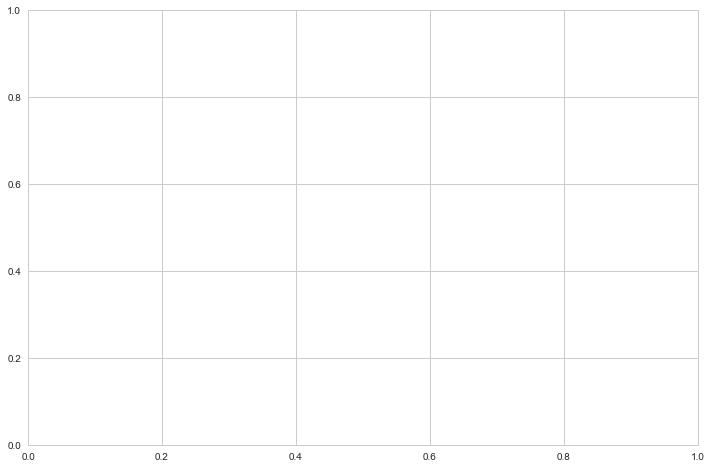

In [20]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 8))

sns.set_color_codes("pastel")
sns.barplot(x=[t1, t2, t3] , y=["LSTM", "SimpleRNN", "GRU"], label="Training time", color="b")

sns.set_color_codes("muted")
sns.barplot(x=[LSTM_steps, SRNN_steps, GRU_steps], y=["LSTM", "SimpleRNN", "GRU"], label="Training Epoch", color="b")



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Epochs/Time(s)")
sns.despine(left=True, bottom=True)
plt.savefig("barplot_softmax.png")
plt.show()

In term of loss TO BE DONE

dict_keys(['val_loss', 'val_categorical_crossentropy', 'loss', 'categorical_crossentropy'])


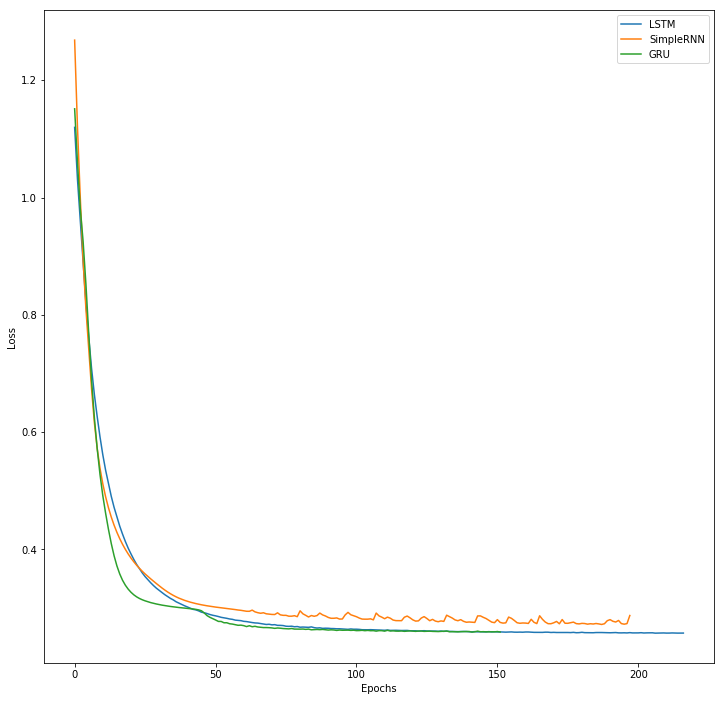

In [15]:
print(history.history.keys())
key_ = list(history.history.keys())[3]
plt.figure(figsize=(12, 12))
plt.plot(history.history[key_], label="LSTM")
plt.plot(history2.history[key_], label="SimpleRNN")
plt.plot(history3.history[key_], label="GRU")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.savefig("loss_softmax.png")
plt.show()

We can see that GRU and LSTM perform better than a Simple RNN. LSTM is also performing slightly better that GRU but require more computation time. We can also check the output and compare it to the real output provided by the graph (see the y description in preparation of data section)

In [80]:
print("Input :")
print(X_val)
print("\n\nLSTM predicts :")
y_pred = model.predict(X_val)
print(np.sum(y_pred, axis=2).reshape(-1,1))
print("\n\nGRU predicts :")
y_pred = model3.predict(X_val)
print(np.sum(y_pred, axis=2).reshape(-1,1))
print("\n\nSRNN predicts :")
y_pred = model2.predict(X_val)
print(y_pred)
print(np.sum(y_pred, axis=2).reshape(-1,1))

Input :
[[[1 0 0 0 0 0 0]
  [0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


LSTM predicts :
[[ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]]


GRU predicts :
[[ 0.974]
 [ 0.807]
 [ 0.719]
 [ 1.184]
 [ 0.944]
 [ 0.999]
 [ 1.426]
 [ 0.957]
 [ 0.999]
 [ 1.212]
 [ 1.52 ]
 [ 0.954]
 [ 0.42 ]
 [ 0.83 ]
 [ 0.903]
 [ 0.944]
 [ 0.976]
 [ 1.005]
 [ 1.022]
 [ 1.029]]


SRNN predicts :
[[[ 0.     0.539  0.001  0.001  0.456  0.001  0.001]
  [ 0.     0.662  0.039  0.051  0.002  0.246  0.   ]
  [ 0.     0.63   0.007  0.005  0.001  0.356  0.   ]
  [ 0.     0.002  0.     0.     0.764  0.232  0.002]
  [

We can simply the output by removing small output and compare it to the possible output (we will only keep prediction from GRU)

In [39]:
# y_pred = np.where(y_pred < 0.1, 0, y_pred)

In [40]:
for pred, real in zip(y_pred[0], y_possible[0]):
    print(pred, "\t", real)

[ 0.     0.54   0.     0.     0.407  0.     0.   ] 	 [0 1 0 0 1 0 0]
[ 0.     0.     0.66   0.314  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.     0.     0.957  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.628  0.     0.     0.     0.372  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.555  0.     0.     0.     0.372  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.996  0.319  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.167  0.55   0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.486  0.     0.     0.     0.51   0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.992  0.499  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.301  0.55   0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.396  0.     0.     0.     0.592  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.689  0.     0.     0.     0.592  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.997  0.592  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.    0.    0.37  0.55  0.    0.    0.  ] 	 [0 0 1 1 0 0 0]
[ 0.     0.327  0.     0.     0.     0.59

Yeah !! Output is balanced between both offset but with different "probabilities". We can also check how well they are to generate sentences

## Use it as generator

As explained previously, we trained our model as a many-to-many RNN. Now we want a generator so we are going to use a one-to-many model but reusing knowledge from the training. 

Before that, we will need an evaluation function which take the output, pick the next input based on the probability to have this output, create the next input and run it until the graph is over. After that, we will check is the created word is really a Reber word. This will be done with following functions 

In [21]:
def Pick_From_Output(x):
    y = np.zeros_like(x)
#     x = np.where(x < 0.1, 0, x)
    x = x[0]/x[0].sum(axis=1)
    i = np.random.choice(list(range(7)), size=1, p=x[0])
    y[0,0,i] = 1
    return y

def evaluate(model, nb_word = 1, max_iter = 100, errors = None):
    good_pred = 0
    if errors is None:
        errors = {1:0, 2:0, 3:0, 4:0}
    for _ in range(nb_word):
        model.reset_states()
        first_input = np.array([[[1,0,0,0,0,0,0]]])
        word = "B"
        loop = 0
        nextLetter = "B"
        next_seq = first_input
        count_E = 0
        while count_E < 2 and loop < max_iter:
            y_pred = model.predict(next_seq)
            next_seq = Pick_From_Output(y_pred)
            nextLetter = reber.sequenceToWord(next_seq[0])
            loop += 1
            word += nextLetter
            if nextLetter == "E":
                count_E += 1
#         print(word)
        code = reber.in_embedded_grammar(word)
        if code == 0:
            good_pred += 1
        else:
#             print(word, code)
            errors[code] += 1
    print(errors)
    acc = 100*good_pred/nb_word
    print("Good prediction : {:.2f}%".format(acc))
    return acc, errors

In [22]:
nb_samples = 20

Now let's create both model as one-to-many and evaluate them 20 times on 100 words generated.

In [23]:
Model = load_model("lstm_simple.h5")  # lstm_simple /  srnn_simple / gru_simple

newModel = Sequential()
newModel.add(LSTM(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.add(Dense(7, activation='softmax'))
newModel.set_weights(Model.get_weights())

In [24]:
error_LSTM = None
result_LSTM = []
for _ in range(nb_samples):
    acc, error_LSTM = evaluate(newModel, 100, 50, error_LSTM)
    result_LSTM.append(acc)
print(error_LSTM)

{1: 0, 2: 0, 3: 55, 4: 2}
Good prediction : 43.00%
{1: 0, 2: 0, 3: 105, 4: 2}
Good prediction : 50.00%
{1: 0, 2: 0, 3: 163, 4: 3}
Good prediction : 41.00%
{1: 0, 2: 0, 3: 221, 4: 4}
Good prediction : 41.00%
{1: 0, 2: 1, 3: 270, 4: 5}
Good prediction : 49.00%
{1: 0, 2: 2, 3: 321, 4: 6}
Good prediction : 47.00%
{1: 0, 2: 3, 3: 371, 4: 6}
Good prediction : 49.00%
{1: 0, 2: 3, 3: 419, 4: 11}
Good prediction : 47.00%
{1: 0, 2: 3, 3: 468, 4: 11}
Good prediction : 51.00%
{1: 0, 2: 3, 3: 519, 4: 13}
Good prediction : 47.00%
{1: 0, 2: 4, 3: 572, 4: 16}
Good prediction : 43.00%
{1: 0, 2: 4, 3: 619, 4: 18}
Good prediction : 51.00%
{1: 0, 2: 4, 3: 666, 4: 22}
Good prediction : 49.00%
{1: 0, 2: 4, 3: 717, 4: 26}
Good prediction : 45.00%
{1: 0, 2: 5, 3: 771, 4: 29}
Good prediction : 42.00%
{1: 0, 2: 5, 3: 825, 4: 30}
Good prediction : 45.00%
{1: 0, 2: 7, 3: 874, 4: 32}
Good prediction : 47.00%
{1: 0, 2: 7, 3: 922, 4: 34}
Good prediction : 50.00%
{1: 0, 2: 8, 3: 973, 4: 36}
Good prediction : 46.00%
{

In [25]:
Model = load_model("srnn_simple.h5")

newModel = Sequential()
newModel.add(SimpleRNN(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.add(Dense(7, activation='softmax'))
newModel.set_weights(Model.get_weights())

In [26]:
error_SRNN = None
result_SRNN = []
for _ in range(nb_samples):
    acc, error_SRNN = evaluate(newModel, 100, 50, error_SRNN)
    result_SRNN.append(acc)
print(error_SRNN)

{1: 0, 2: 0, 3: 49, 4: 1}
Good prediction : 50.00%
{1: 0, 2: 0, 3: 89, 4: 3}
Good prediction : 58.00%
{1: 0, 2: 0, 3: 137, 4: 7}
Good prediction : 48.00%
{1: 0, 2: 0, 3: 181, 4: 9}
Good prediction : 54.00%
{1: 0, 2: 0, 3: 230, 4: 9}
Good prediction : 51.00%
{1: 0, 2: 0, 3: 275, 4: 11}
Good prediction : 53.00%
{1: 0, 2: 0, 3: 320, 4: 13}
Good prediction : 53.00%
{1: 0, 2: 0, 3: 384, 4: 14}
Good prediction : 35.00%
{1: 0, 2: 1, 3: 434, 4: 14}
Good prediction : 49.00%
{1: 0, 2: 1, 3: 489, 4: 15}
Good prediction : 44.00%
{1: 0, 2: 1, 3: 533, 4: 16}
Good prediction : 55.00%
{1: 0, 2: 1, 3: 582, 4: 19}
Good prediction : 48.00%
{1: 0, 2: 1, 3: 636, 4: 21}
Good prediction : 44.00%
{1: 0, 2: 1, 3: 688, 4: 24}
Good prediction : 45.00%
{1: 0, 2: 1, 3: 748, 4: 25}
Good prediction : 39.00%
{1: 0, 2: 3, 3: 797, 4: 29}
Good prediction : 45.00%
{1: 0, 2: 3, 3: 847, 4: 34}
Good prediction : 45.00%
{1: 0, 2: 3, 3: 906, 4: 36}
Good prediction : 39.00%
{1: 0, 2: 3, 3: 956, 4: 38}
Good prediction : 48.00%


In [ ]:
Model = load_model("gru_simple.h5")

newModel = Sequential()
newModel.add(GRU(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.add(Dense(7, activation='softmax'))
newModel.set_weights(Model.get_weights())

In [ ]:
error_GRU = None
result_GRU = []
for _ in range(nb_samples):
    acc, error_GRU = evaluate(newModel, 100, 50, error_GRU)
    result_GRU.append(acc)
error_GRU

{1: 0, 2: 0, 3: 58, 4: 3}
Good prediction : 39.00%
{1: 0, 2: 1, 3: 106, 4: 6}
Good prediction : 48.00%
{1: 0, 2: 1, 3: 168, 4: 7}
Good prediction : 37.00%
{1: 0, 2: 1, 3: 218, 4: 10}
Good prediction : 47.00%
{1: 0, 2: 1, 3: 264, 4: 13}
Good prediction : 51.00%
{1: 0, 2: 2, 3: 318, 4: 13}
Good prediction : 45.00%
{1: 0, 2: 2, 3: 358, 4: 14}
Good prediction : 59.00%
{1: 0, 2: 4, 3: 401, 4: 19}
Good prediction : 50.00%
{1: 0, 2: 4, 3: 448, 4: 23}
Good prediction : 49.00%
{1: 0, 2: 4, 3: 499, 4: 27}
Good prediction : 45.00%


In [19]:
import pandas as pd

d = {'LSTM': result_LSTM, 'Simple RNN': result_SRNN, 'GRU' : result_GRU}
df = pd.DataFrame(data=d)

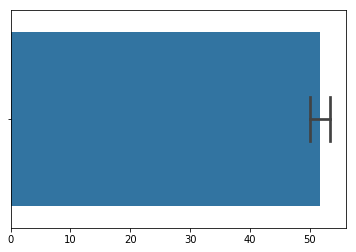

In [13]:
# sns.barplot(x=["LSTM", "Simple RNN", "GRU"], data=df, capsize=.2)

So we can see that bost LSTM and GRU outperform the standard RNN. In average LSTM is slightly better than GRU but takes also more time to train.

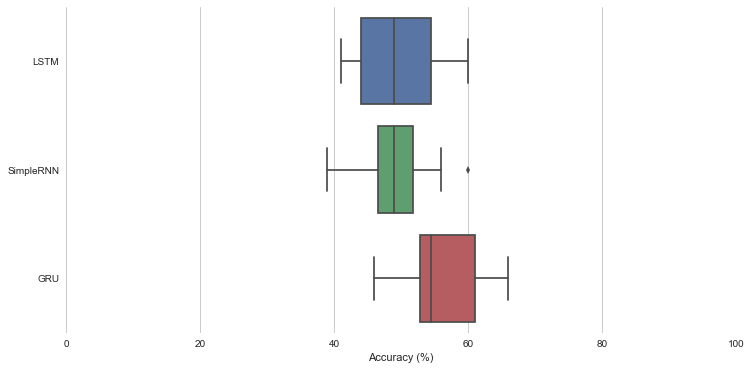

In [20]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 6))

ax = sns.boxplot(x=[result_LSTM, result_SRNN, result_GRU], y=["LSTM", "SimpleRNN", "GRU"])
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Accuracy (%)")
sns.despine(left=True, bottom=True)
plt.savefig("boxplot.png")
plt.show()

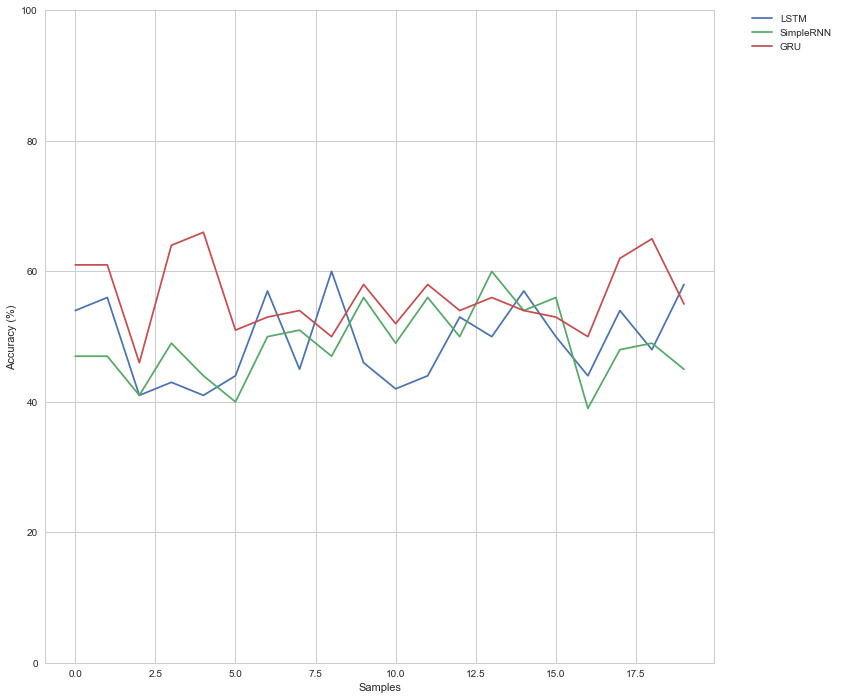

In [21]:
x = list(range(nb_samples))
y = [result_LSTM, result_SRNN, result_GRU]
labels = ["LSTM", "SimpleRNN", "GRU"]

plt.figure(figsize=(12, 12))
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)


plt.xlabel("Samples")
plt.ylabel("Accuracy (%)")
plt.ylim((0,100))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("test_result.png")
plt.show()

In [50]:
df3 = pd.DataFrame(data=error_LSTM, index=["LSTM"])
df3 = df3.append(pd.DataFrame(data=error_GRU, index=["GRU"]))
df3 = df3.append(pd.DataFrame(data=error_SRNN, index=["SRNN"]))
df3.columns = ["1st Letter", "2nd Letter", "LTM", "Reber"]

In [51]:
df3

,1st Letter,2nd Letter,LTM,Reber
LSTM,0,2,985,26
GRU,0,1,865,11
SRNN,0,3,1001,18


## Conclusion

In this workbook, we started to go through RNN. We check a simple model of both LSTM, GRU and SimpleRNN to check how fast and well they learn. On this example GRU and LSTM outperform the standard RNN due to the memory function. There is also a difference between LSTM and GRU but with slightly more epochs, they both perform similar. We can probably have better result by using a more advanced model but for such a simple model, we can see that it works really well.

## Going further

On a future notebook, we will explore Embedded Reber but using deeper RNNs